# Instantaneous vehicle fuel consumption estimation using smartphones and recurrent neural networks
References:
* Kanarachos S., Mathew J., Fitzpatrick M. E. **Instantaneous vehicle fuel consumption estimation using smartphones and recurrent neural networks**. _Expert Systems With Applications 120 (2019) 436–447_ https://www.sciencedirect.com/science/article/pii/S0957417418307681?via%3Dihub

In [68]:
import sys
import sqlite3
import tensorflow.keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error

In [69]:
def get_data(size=None):
    date_previous, date_current, distance, speed, fuel_consumption =  ([] for i in range(5))
    try:
        database_name = '../data.db'
        sqliteConnection = sqlite3.connect(database_name)
        cursor = sqliteConnection.cursor()
        cursor.execute('''select date_previous, date_current, distance, speed, fuel_consumption from data''')
        if isinstance(size, int):
            records = cursor.fetchmany(size)
        else:
            records = cursor.fetchall()
        for row in records:
            date_previous.append(row[0])
            date_current.append(row[1])
            distance.append(row[2])
            speed.append(row[3])
            fuel_consumption.append(row[4])
        cursor.close()
        sqliteConnection.close()

    except sqlite3.Error as error:
        print('Failed to read data from sqlite table', error)

    return date_previous, date_current, distance, speed, fuel_consumption

    
def get_part_of_data(data, _from, to):
    inputs = np.array(data['speed'][_from:to])
    outputs = np.array(data['fuel consumption'][_from:to])
    return inputs, outputs


def divide_into_parts(inputs, outputs, train_part):
    length = inputs.shape[0]
    train_part *= length
    validation_part = train_part + (length - train_part)   
    
    train_array = [inputs[: int(train_part)],
                   outputs[: int(train_part)]]
    
    validation_array = [inputs[int(train_part) : int(validation_part)],
                        outputs[int(train_part) : int(validation_part)]]
        
    return train_array, validation_array


def transform(array):
    return array.reshape(array.shape[0], 1, 1)


def transform_to_list(array):
    return array.reshape(array.shape[0])

        
def statistics(real, predict):
    print(f'mean absolute error: {mean_absolute_error(np.array(real), np.array(predict))}')

    
def calculate_fuel_consumption(v):
    """
    engine: 1.4L - 2.0L
    Car class: Euro I - IV
    -----------------------
    v: car speed [km/h]
    FC: fuel consumption [l/100 km]
    """
    if v == 0:
        fuel_consumption = 0
    elif v > 13.1:
        fuel_consumption = 135.44 - 2.314 * v + 0.0144 * v ** 2
    else:
        fuel_consumption = 428.06 - 46.696 * v + 1.531 * v ** 2
    fuel_consumption = fuel_consumption / 10  # conversion of units [g/km] -> [kg/100km]
    fuel_consumption = fuel_consumption / 0.8  # conversion of units  kg -> litres
    return fuel_consumption


def plot_hist(data, title):
    plt.figure(figsize=(10,6))
    plt.hist(data, rwidth=0.91)
    plt.title(title)
    plt.show()
    
    
def plot_part_of_data(data, title, _from, to):
    plt.figure(figsize=(10,6))
    plt.plot(data[_from:to], color='blue', marker='.', alpha=0.5, linestyle='None')
    plt.title(title)
    plt.show()
    
    
def plot_result(x, y_real, y_predict):
    plt.figure(figsize=(15,9))
    plt.plot(x, y_real, color='red', alpha=0.5, marker='.', linestyle='None', label='rzeczywiste')
    plt.plot(x, y_predict, color='blue', alpha=0.5, marker='.', linestyle='None', label='przewidywane')
    plt.plot(x, np.zeros(len(x)), color='black')
    plt.legend()
    plt.show()    

## reading data from the database

In [25]:
data = get_data(1000000)

## creating Pandas DataFrame

In [26]:
data = pd.DataFrame({'date previous':data[0],
                     'date current':data[1],
                     'distance':data[2],
                     'speed':data[3],
                     'fuel consumption':data[4]})

In [27]:
data.head(100)

,date previous,date current,distance,speed,fuel consumption
0,2008-02-02 15:36:08,2008-02-02 15:36:38,0.097864,11.743710,11.352895
1,2008-02-02 15:36:38,2008-02-02 15:37:08,0.097766,11.731966,11.368683
2,2008-02-02 15:37:08,2008-02-02 15:37:38,0.099047,11.885646,11.166259
3,2008-02-02 15:37:38,2008-02-02 15:38:08,0.100298,12.035758,10.977262
4,2008-02-02 15:38:08,2008-02-02 15:38:38,0.101520,12.182383,10.800981
...,...,...,...,...,...
95,2008-02-02 15:41:38,2008-02-02 15:42:08,0.091682,11.001801,12.453947
96,2008-02-02 15:42:08,2008-02-02 15:42:38,0.091051,10.926087,12.578158
97,2008-02-02 15:42:38,2008-02-02 15:43:08,0.090434,10.852132,12.701603
98,2008-02-02 15:43:08,2008-02-02 15:43:38,0.089832,10.779895,12.824203


## statistics

In [28]:
data.describe()

,distance,speed,fuel consumption
count,1000000.000000,1000000.000000,1000000.000000
mean,0.107886,12.946343,22.442683
std,0.129975,15.596952,18.435552
min,0.000000,0.000000,0.000000
25%,0.001265,0.151799,10.153780
50%,0.071091,8.530978,12.917241
75%,0.161200,19.343972,40.598003
max,1.079671,129.560565,53.507500


In [58]:
_from, to = 200, 599

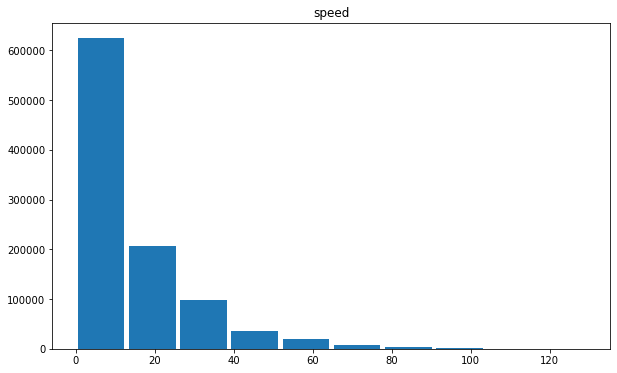

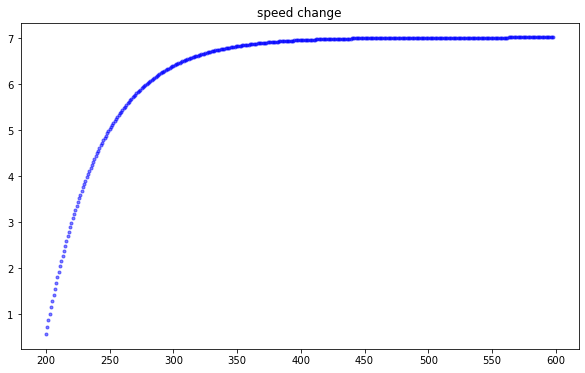

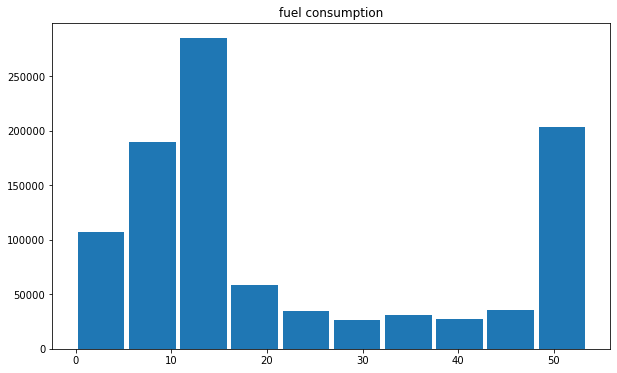

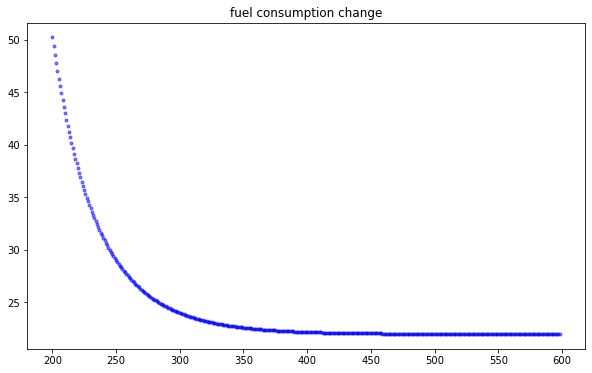

In [60]:
speed, fuel_consumption = data['speed'], data['fuel consumption']

plot_hist(speed, 'speed')
plot_part_of_data(speed, 'speed change', _from, to)

plot_hist(fuel_consumption, 'fuel consumption')
plot_part_of_data(fuel_consumption, 'fuel consumption change', _from, to)

## data preparation

In [30]:
train, validation = divide_into_parts(get_part_of_data(data, 0, 900000)[0], get_part_of_data(data, 0, 900000)[1], 0.8)

test = get_part_of_data(data, 900000, 1000000)

train_inputs = transform(train[0])
validation_inputs = transform(validation[0])
test_inputs = transform(test[0])

train_outputs = train[1]
validation_outputs = validation[1]
test_outputs = test[1]

## construction of recurrent neural network
References:
* https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/

In [31]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## learning process

In [32]:
model.fit(train_inputs, train_outputs, epochs=20, batch_size=5,
          validation_data=(validation_inputs, validation_outputs))

Train on 720000 samples, validate on 180000 samples
Epoch 1/20
720000/720000 [==============================] - 254s 352us/sample - loss: 141.5159 - accuracy: 1.4722e-04 - val_loss: 86.5600 - val_accuracy: 0.0000e+00
Epoch 2/20
720000/720000 [==============================] - 257s 356us/sample - loss: 91.3751 - accuracy: 0.0000e+00 - val_loss: 62.8669 - val_accuracy: 0.0000e+00
Epoch 3/20
720000/720000 [==============================] - 263s 366us/sample - loss: 75.9392 - accuracy: 0.0000e+00 - val_loss: 55.2964 - val_accuracy: 0.0000e+00
Epoch 4/20
720000/720000 [==============================] - 262s 364us/sample - loss: 69.0881 - accuracy: 0.0000e+00 - val_loss: 50.2685 - val_accuracy: 0.0000e+00
Epoch 5/20
720000/720000 [==============================] - 263s 365us/sample - loss: 64.0921 - accuracy: 0.0000e+00 - val_loss: 47.4137 - val_accuracy: 0.0000e+00
Epoch 6/20
720000/720000 [==============================] - 261s 363us/sample - loss: 60.0151 - accuracy: 0.0000e+00 - val_loss

## prediction

In [33]:
test_predictions = model.predict(test_inputs)

## data formatting

In [34]:
predictions = transform_to_list(test_predictions)
test_inputs = transform_to_list(test_inputs)

## result

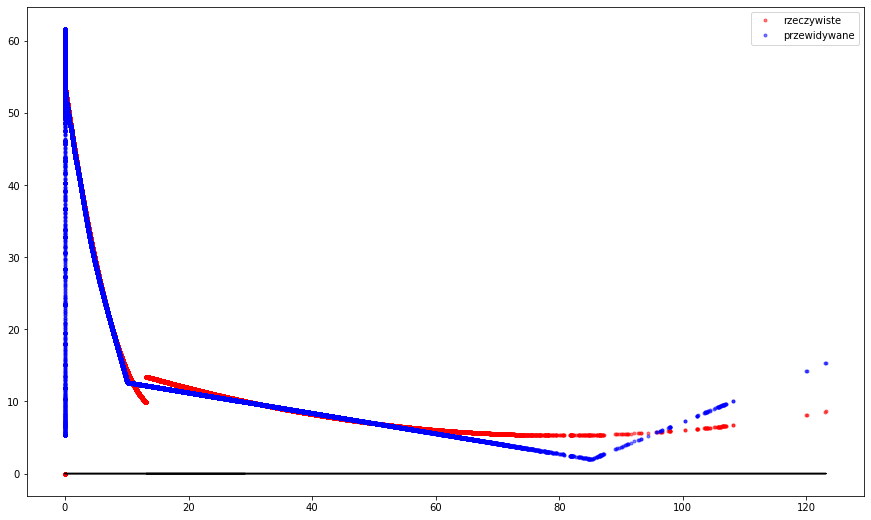

In [37]:
plot_result(test_inputs, test_outputs, predictions)

In [70]:
statistics(test_outputs, predictions)

mean absolute error: 1.054032061140612
